<a href="https://colab.research.google.com/github/RonakMehta21/Machine-Learning/blob/master/Reading_2_Clustering%2C_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Gaussian Mixture Models

A Gaussian mixture model (mixture of Gaussians) is a mixture of multi-dimensional normal distribution(probability distributions) that fits any input dataset.

* It's a soft clustering instead of distinct clusters and has a bunch of density functions.

#### Definition from "scikit-learn.org": 
A probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 

## Mathematically
A Gaussian Mixture is a function that is comprised of several Gaussians, each identified by k ∈ {1,…, K}, where K is the number of clusters of our dataset. Each Gaussian k in the mixture is comprised of the following parameters:
1. A mean μ that defines its centre.
2. A covariance Σ that defines its width. This would be equivalent to the dimensions of an ellipsoid in a multivariate scenario.
3. A mixing probability π that defines how big or small the Gaussian function will be.

### Advantages of Gaussian Mixture model over K-Means:
1. Gaussian Mixture model does not bias the cluster sizes to have specific structures as with K-Means (Circular).
2. Works well with non-linear geometric distributions as well.
3. The non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.

### Disvantages of Gaussian Mixture model over K-Means:
1. It is difficult to interpret.
2. Initialization of clusters will be difficult when dimensionality of data is high.

### Algorithm

Gaussian Mixter model uses `Expectation-Maximization` (EM) algorithm for fitting mixture of gaussians models.
It comes with different options to constrain the covariance of the difference classes estimated: spherical, diagonal, tied or full covariance.

The EM algorithm is used to find (local) maximum likelihood parameters of a statistical model in cases where the equations cannot be solved directly.
Gaussian Mixter models from unlabeled data doesn't know which data points came from which latent components. It uses EM algorithm to first assume random components (Random centered on data points learned from K-Means) and computes for each point a probability of being generated by each component of the model.
Then, the parameters are tweaked to maximize the likelihood of the data given those assignments. Repeating this process will always converge to a local optimum.

**"Maximum Likelihood from Incomplete Data via the EM Algorithm"**, a paper by A. P. DEMPSTER, N. M. LAIRD and D. B. RUBIN explains the above algorithm for computing the maximum likelihood from incomplete data where the convergence of the algorithm is derived. Many examples are sketched, including missing value situations, applications to grouped, censored or truncated data, finite mixture models, variance component estimation, hyperparameter estimation, iteratively reweighted least squares and factor analysis 

### A closer look at GMMs with an extension to K-Means

In [0]:
#import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

K-Means easily clusters datapoints which can be easily differentiated with naked-eye as the below code explains

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


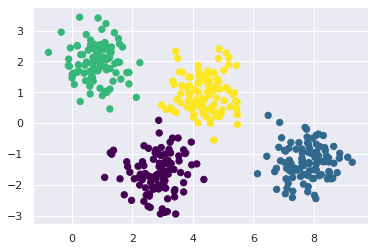

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

There might be a simple overlap between two middle clusters. K-Means cannot provide uncertainity of the cluster assignments. So in this case we might generalize the model.

K-Means model places a circle or a hyper-sphere in higher dimension at the center of each cluster with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [0]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

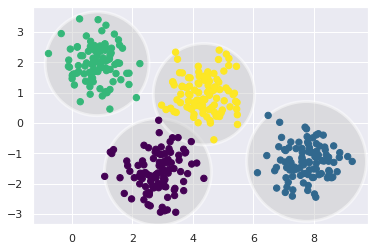

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

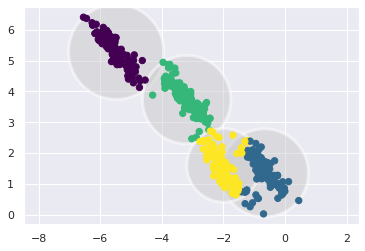

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

With the naked-eye we can ensure that these circular cluster are a poor fit. K-Means tries to force-fit data into circular clusters. This results in mixing of circular clusters, especially the botton right one.

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

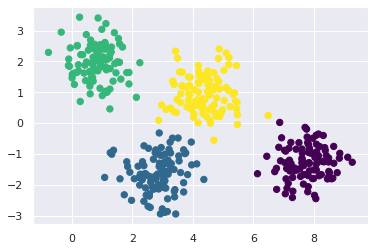

In [8]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

To find probabilistic cluster assignments—in Scikit-Learn this is done using the `predict_proba` method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.    0.    0.531]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]]


Looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

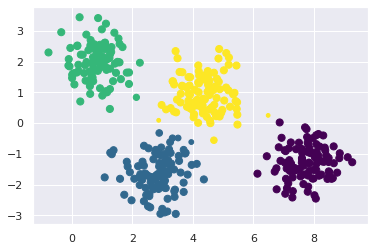

In [10]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

A Gaussian mixture model uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [0]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

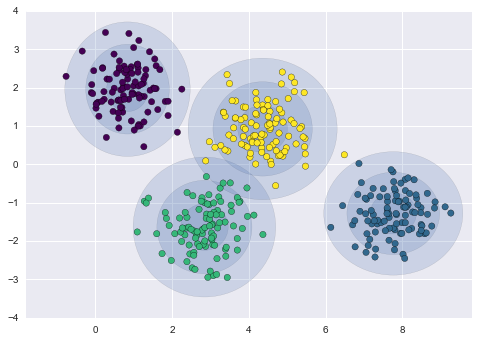

In [0]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

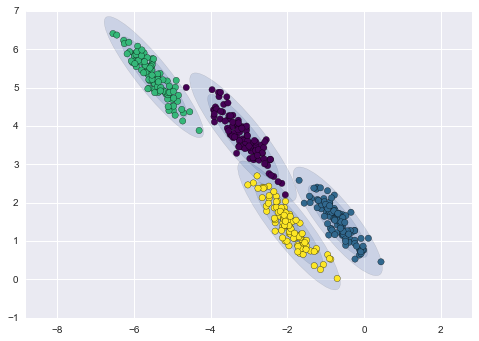

In [0]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which we saw in [In Depth: K-Means Clustering](05.11-K-Means.ipynb):

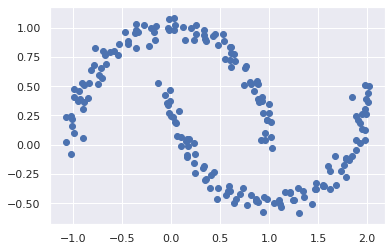

In [18]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

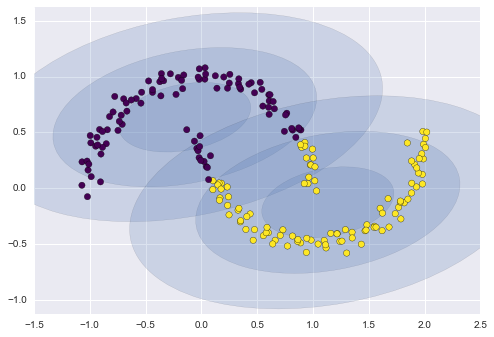

In [0]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

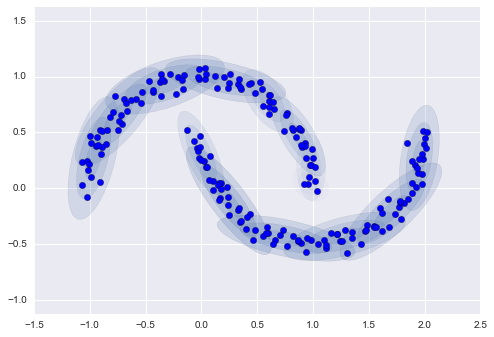

In [0]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

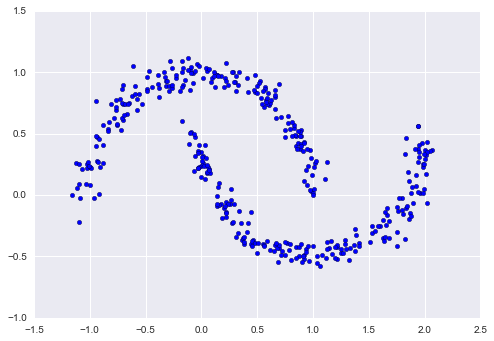

In [0]:
Xnew = gmm16.sample(400, random_state=42)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

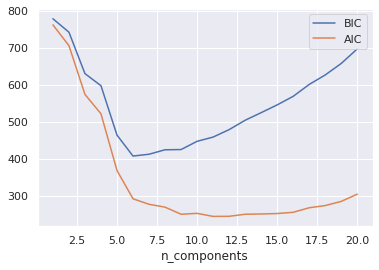

In [25]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

## Example: GMM for Generating New Data

We just saw a simple example of using GMM as a generative model of data in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [26]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Next let's plot the first 100 of these to recall exactly what we're looking at:

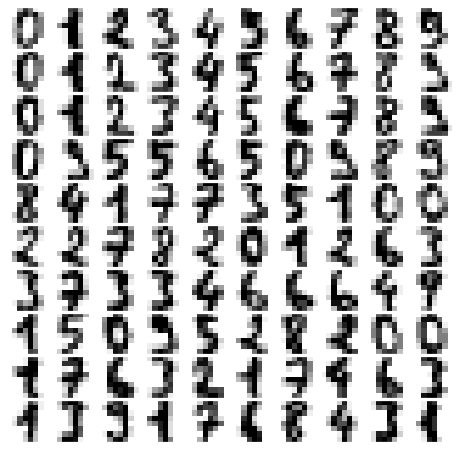

In [27]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.
GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.
Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

In [28]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.
Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

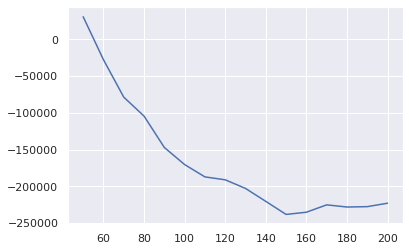

In [30]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 110 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

In [37]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


## To show the four types of Gaussians using Iris Data set

In [0]:
## Import necessary libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

In [0]:
colors = ['navy', 'turquoise', 'darkorange']
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

In [0]:
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

In [42]:
X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

<Figure size 432x432 with 0 Axes>

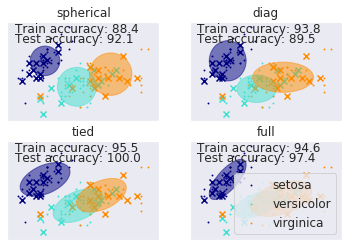

In [43]:
for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

## Hierarchial Clustering

It's a method of cluster analysis which builds a hierarchy of clusters. It has two types:
1. Agglomerative Clustering
2. Divisive Clustering

The below code shows agglomerative clustering

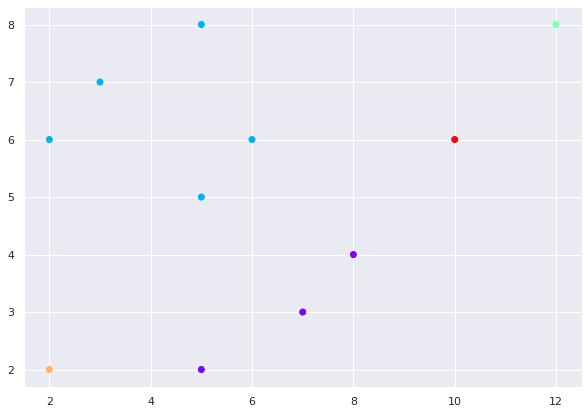

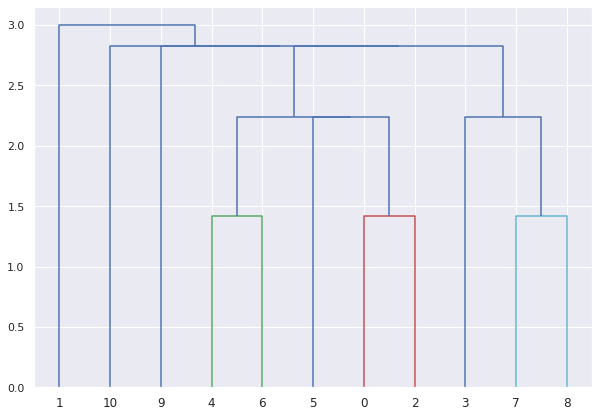

In [46]:
## Imported Libraries for clustering the given points
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
## Store the points in a numpy array
X = np.array([[2,6], [2,2], [3,7], [5,2], [5,5], [5,8], [6,6], [7,3],
[8,4], [10,6], [12,8]])
##I have divided the following points into 5 clusters using single-link clustering technique
singleClustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean',linkage='single').fit(X)
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1], c=singleClustering.labels_, cmap='rainbow')
single=hierarchy.linkage(X,'single')
plt.figure(figsize=(10,7))
dnSingle = hierarchy.dendrogram(single)

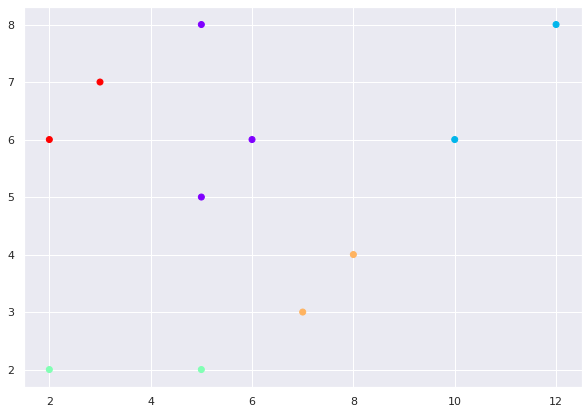

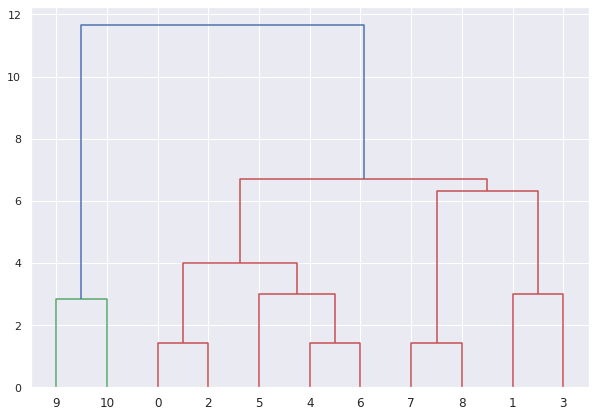

In [48]:
##I have divided the given points into 5 clusters using complete-link clustering technique
completeClustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean',linkage='complete').fit(X)
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1], c=completeClustering.labels_, cmap='rainbow')
complete = hierarchy.linkage(X,'complete')
plt.figure(figsize=(10,7))
dnComplete = hierarchy.dendrogram(complete)

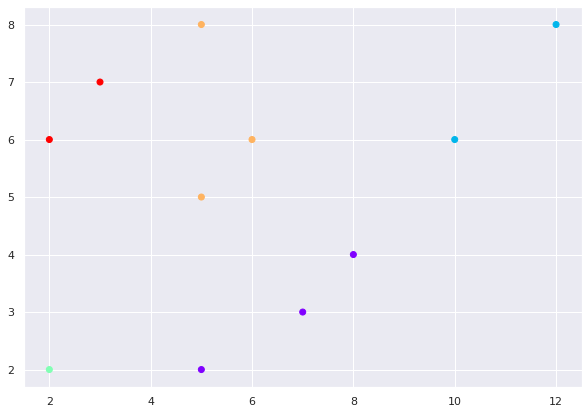

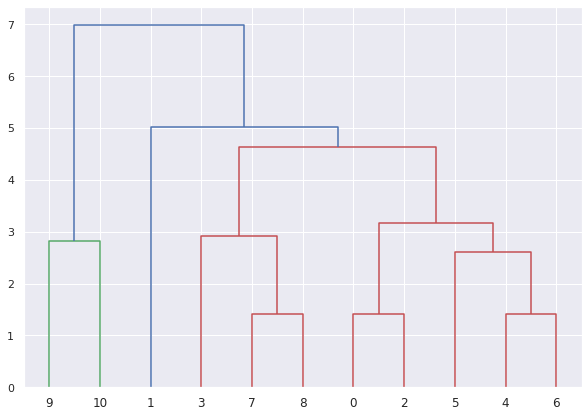

In [49]:
##I have divided the following points into 5 clusters using average-li nk clustering technique
averageClustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean',linkage='average').fit(X)
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1], c=averageClustering.labels_, cmap='rainbow')
average = hierarchy.linkage(X,'average')
plt.figure(figsize=(10,7))
dnAverage = hierarchy.dendrogram(average)